In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image,ImageDraw
import random

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image,ImageDraw
import random
import math
import cv2
import skimage.exposure
import torchvision.models as models
import torchvision.transforms as transforms
from tqdm import tqdm

# Sprawdzenie spojnosci jpg i csv

In [16]:
import os
import pandas as pd

def validate_csv(csv_file, root_dir, output_csv):
    """
    Validate the CSV file by checking if the files exist in the dataset directory.
    Remove missing files and save a new CSV file.
    
    Args:
    - csv_file (str): Path to the input CSV file.
    - root_dir (str): Path to the dataset directory containing the images.
    - output_csv (str): Path to save the validated CSV file.
    """
    df = pd.read_csv(csv_file)
    
    valid_rows = []
    
    for idx, row in df.iterrows():

        img_path = os.path.join(root_dir, row[0])
        
        # Check if the file exists
        if os.path.exists(img_path):
            valid_rows.append(row)  # Keep valid rows
        else:
            print(f"File not found, skipping: {img_path}")
    

    valid_df = pd.DataFrame(valid_rows, columns=df.columns)
    

    valid_df.to_csv(output_csv, index=False)
    print(f"Validated CSV saved to {output_csv}")


csv_file = "wclasses.csv"   # Path to your original CSV file
root_dir = r"C:\Users\Adas\Desktop\sium sem 2\UNN\UN_projekyt\WikiArt-Impainting_Images-master"    # Path to your dataset directory
output_csv = 'validated_csv.csv'        # Path to save the new CSV file

validate_csv(csv_file, root_dir, output_csv)


C:\Users\Adas\AppData\Local\Temp\ipykernel_21044\674298775.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img_path = os.path.join(root_dir, row[0])


File not found, skipping: C:\Users\Adas\Desktop\sium sem 2\UNN\UN_projekyt\WikiArt-Impainting_Images-master\Impressionism/joaquã­n-sorolla_mending-the-sail-1896.jpg
File not found, skipping: C:\Users\Adas\Desktop\sium sem 2\UNN\UN_projekyt\WikiArt-Impainting_Images-master\Naive_Art_Primitivism/grã©goire-michonze_figures-in-the-village(2).jpg
File not found, skipping: C:\Users\Adas\Desktop\sium sem 2\UNN\UN_projekyt\WikiArt-Impainting_Images-master\Naive_Art_Primitivism/grã©goire-michonze_figures-in-a-room-1981.jpg
File not found, skipping: C:\Users\Adas\Desktop\sium sem 2\UNN\UN_projekyt\WikiArt-Impainting_Images-master\Impressionism/joaquã­n-sorolla_boat-in-albufera-1908.jpg
File not found, skipping: C:\Users\Adas\Desktop\sium sem 2\UNN\UN_projekyt\WikiArt-Impainting_Images-master\Impressionism/joaquã­n-sorolla_raimundo-de-madrazo-in-his-paris-garden-1906.jpg
File not found, skipping: C:\Users\Adas\Desktop\sium sem 2\UNN\UN_projekyt\WikiArt-Impainting_Images-master\Romanticism/pierre-

In [38]:
import pandas as pd
import numpy as np

def split_csv(input_csv, train_csv, test_csv, train_ratio=0.99, random_seed=42):
    """
    Split a CSV file into training and testing datasets.

    Args:
    - input_csv (str): Path to the input CSV file.
    - train_csv (str): Path to save the training CSV file.
    - test_csv (str): Path to save the testing CSV file.
    - train_ratio (float): Ratio of data to be used for training (default is 0.99).
    - random_seed (int): Seed for random number generator to ensure reproducibility.
    """
    # Load the validated CSV file
    df = pd.read_csv(input_csv)

    # Shuffle the data with a fixed random seed
    df_shuffled = df.sample(frac=1, random_state=random_seed).reset_index(drop=True)

    # Calculate the split index
    split_idx = int(len(df_shuffled) * train_ratio)

    # Split into train and test datasets
    train_df = df_shuffled[:split_idx]
    test_df = df_shuffled[split_idx:]

    # Save the split datasets to CSV files
    train_df.to_csv(train_csv, index=False)
    test_df.to_csv(test_csv, index=False)

    print(f"Training data saved to {train_csv} ({len(train_df)} samples)")
    print(f"Testing data saved to {test_csv} ({len(test_df)} samples)")

# Paths to the output files
input_csv = 'validated_csv.csv'  # Path to the validated CSV file
train_csv = 'validate_csv_train.csv'  # Path to save the training CSV file
test_csv = 'validate_csv_test.csv'    # Path to save the testing CSV file

# Call the function to split the CSV
split_csv(input_csv, train_csv, test_csv)

Training data saved to validate_csv_train.csv (79868 samples)
Testing data saved to validate_csv_test.csv (807 samples)


In [15]:
#14.12

# Feature extractor

In [23]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
from torchvision import models
from tqdm import tqdm

# Dataset Class
class WikiArtDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.df = pd.read_csv(csv_file)  # Load CSV with file paths and labels
        self.root_dir = root_dir
        self.transform = transform if transform else transforms.Compose([
            transforms.Resize((224, 224)),  # Resize to ResNet input size
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
        ])
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.df.iloc[idx, 0])  # Image path
        image = Image.open(img_path).convert('RGB')  # Open image in RGB mode
        label = self.df.iloc[idx, 1]  # Corresponding label

        if self.transform:
            image = self.transform(image)  # Apply transformations

        return image, label  # Return image and label


In [24]:
# Dataset and DataLoader
root_dir = r"C:\Users\Adas\Desktop\sium sem 2\UNN\UN_projekyt\WikiArt-Impainting_Images-master"
csv_file = "validate_csv_train.csv"

# Initialize Dataset and DataLoader
dataset = WikiArtDataset(csv_file=csv_file, root_dir=root_dir)

# Use DataLoader for batching and shuffling
batch_size = 16
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)


In [25]:
import torch
import torch.nn as nn
from torchvision import models

# Load Pretrained ResNet18
resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Remove the fully connected (FC) layers to get raw features
feature_extractor = torch.nn.Sequential(*list(resnet.children())[:-1])

# Define the new fully connected layer for latent space of size 200
latent_dim = 200
fc_layer = nn.Linear(512, latent_dim)

# Combine feature extractor and new FC layer
class ModifiedResNet18(nn.Module):
    def __init__(self, feature_extractor, fc_layer):
        super(ModifiedResNet18, self).__init__()
        self.feature_extractor = feature_extractor
        self.fc_layer = fc_layer

    def forward(self, x):
        # Pass through the feature extractor
        features = self.feature_extractor(x)
        # Flatten the features from [batch_size, 512, 1, 1] to [batch_size, 512]
        features = features.view(features.size(0), -1)
        # Pass through the fully connected layer
        latent_space = self.fc_layer(features)
        return latent_space

# Initialize the modified ResNet-18 model
modified_resnet = ModifiedResNet18(feature_extractor, fc_layer)

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modified_resnet = modified_resnet.to(device)

# Print the model architecture (optional)
print(modified_resnet)


ModifiedResNet18(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match ResNet input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

dataset = WikiArtDataset(
    csv_file="validate_csv_train.csv",
    root_dir=r"C:\Users\Adas\Desktop\sium sem 2\UNN\UN_projekyt\WikiArt-Impainting_Images-master",
    transform=transform
)
dataloader = DataLoader(dataset, batch_size=16, shuffle=False) #check what shuffle true is getting

# Extract Features
latent_vectors = []
with torch.no_grad():  # Disable gradient computation for faster processing
    for images, _ in tqdm(dataloader, desc="Extracting Features"):
        images = images.to(device)
        latent_space = modified_resnet(images)  # Pass images through the modified model
        latent_vectors.append(latent_space.cpu())  # Move to CPU and store

# Combine all features into a single tensor
latent_vectors = torch.cat(latent_vectors, dim=0)

# Save Latent Vectors
torch.save(latent_vectors, "latent_vectors_200.pt")


Extracting Features: 100%|██████████| 4992/4992 [45:18<00:00,  1.84it/s]


In [52]:
import torch
import numpy as np
from sklearn.decomposition import PCA

# Load latent vectors
latent_vectors = torch.load("latent_vectors_200.pt")

# Convert latent vectors to NumPy for use in scikit-learn
latent_vectors = latent_vectors.numpy()

# Initialize PCA
pca = PCA()

# Fit PCA on latent vectors
pca.fit(latent_vectors)

# Calculate cumulative explained variance ratio
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components required to retain at least 90% variance
num_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
print(f"Number of components to retain 90% variance: {num_components_90}")


pca_components = PCA(n_components=num_components_90)
reduced_latent_vectors = pca_components.fit_transform(latent_vectors)

# Save the reduced latent vectors
np.save("reduced_latent_vectors_200.npy", reduced_latent_vectors)

# Save PCA model for later use if needed
import joblib
joblib.dump(pca_components, "pca_4_components_200.pkl")

C:\Users\Adas\AppData\Local\Temp\ipykernel_22312\1716108102.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  latent_vectors = torch.load("latent_vectors_200.pt")


Number of components to retain 90% variance: 102


['pca_4_components_200.pkl']

In [53]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import os
import joblib
# Load reduced latent vectors
reduced_latent_vectors = np.load("reduced_latent_vectors_200.npy")

# Perform initial K-Means clustering
k = 10 # Replace with your desired number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(reduced_latent_vectors)

# Load the original CSV file to get the image paths
original_csv = "validate_csv_train.csv"
df = pd.read_csv(original_csv)

# Add cluster assignments to the DataFrame
df["cluster_200"] = clusters

# Count the number of images in each cluster
cluster_counts = df["cluster_200"].value_counts().to_dict()

# Check for clusters with fewer than 1500 images
cluster_centers = kmeans.cluster_centers_
reassignments = {}

while True:
    small_clusters = {cluster: count for cluster, count in cluster_counts.items() if count < 1500}
    if not small_clusters:
        break

    for small_cluster in small_clusters:
        # Calculate distances from the small cluster's center to other cluster centers
        distances = cdist([cluster_centers[small_cluster]], cluster_centers, metric='euclidean')[0]
        distances[small_cluster] = np.inf  # Ignore the small cluster itself

        # Find the nearest cluster
        nearest_cluster = np.argmin(distances)
        
        # Combine clusters if the total size is >= 1500
        combined_size = cluster_counts[small_cluster] + cluster_counts.get(nearest_cluster, 0)
        if combined_size >= 1500:
            print(f"Cluster {small_cluster} has too few images ({cluster_counts[small_cluster]}) and is added to cluster {nearest_cluster}")
            reassignments[small_cluster] = nearest_cluster
            cluster_counts[nearest_cluster] = combined_size
            del cluster_counts[small_cluster]

    # Update the DataFrame with reassigned clusters
    for small_cluster, nearest_cluster in reassignments.items():
        df.loc[df["cluster_200"] == small_cluster, "cluster_200"] = nearest_cluster

    # Update cluster counts and reassignments for the next iteration
    cluster_counts = df["cluster_200"].value_counts().to_dict()
    reassignments = {}

# Print final cluster information
real_clusters = len(cluster_counts)
print(f"Number of real clusters formed: {real_clusters}")

joblib.dump(kmeans, "kmeans_102_clusters.pkl")

# Update cluster labels to reflect contiguous numbering
unique_clusters = sorted(cluster_counts.keys())
cluster_mapping = {old: new for new, old in enumerate(unique_clusters)}
df["cluster_200"] = df["cluster_200"].map(cluster_mapping)

# Save cluster information to separate CSVs based on real clusters
output_dir = "clusters_csv_200"
os.makedirs(output_dir, exist_ok=True)

for new_cluster_num in range(real_clusters):
    cluster_df = df[df["cluster_200"] == new_cluster_num]
    cluster_csv_path = os.path.join(output_dir, f"validated_csv_cluster_{new_cluster_num}.csv")
    cluster_df.to_csv(cluster_csv_path, index=False)

print(f"Cluster CSV files saved in directory: {output_dir}")


C:\Users\Adas\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of real clusters formed: 10
Cluster CSV files saved in directory: clusters_csv_200


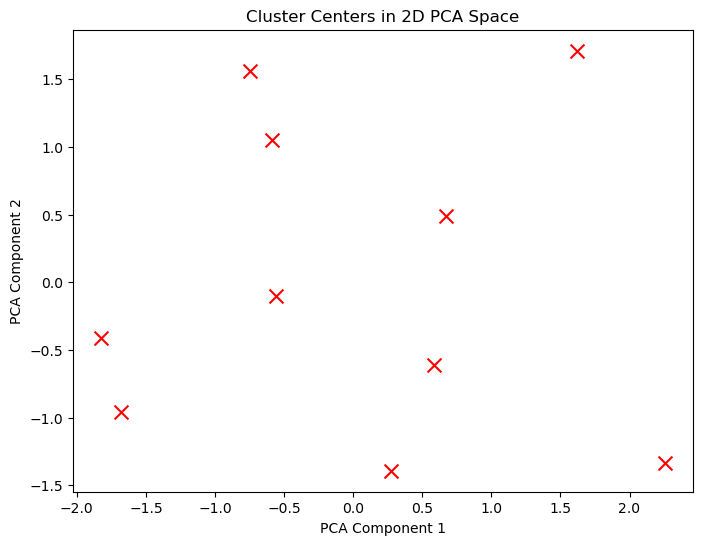

Cluster Centers (in latent space):
 (10, 102)


In [55]:
import torch
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA  

# Load latent vectors
#latent_vectors = torch.load("latent_vectors.pt")
#latent_vectors = reduced_latent_vectors

# Convert latent vectors to NumPy for use in scikit-learn
#latent_vectors = latent_vectors.numpy()

# Number of clusters
#k = 15  # Replace with your desired number of clusters
#kmeans = KMeans(n_clusters=k, random_state=42)
#clusters = kmeans.fit_predict(reduced_latent_vectors)

# Get the cluster centers
#cluster_centers = kmeans.cluster_centers_

# Use PCA to reduce the cluster centers to 2D for visualization
original_cluster_centers = kmeans.cluster_centers_  # This remains in 102 features


pca = PCA(n_components=2)
reduced_centers = pca.fit_transform(cluster_centers)

# Plot only the cluster centers
plt.figure(figsize=(8, 6))
plt.scatter(reduced_centers[:, 0], reduced_centers[:, 1], c='red', marker='x', s=100)  # Plot cluster centers
plt.title("Cluster Centers in 2D PCA Space")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

print("Cluster Centers (in latent space):\n", cluster_centers.shape)


# trenowanie autoenkodera do inpaintingu

In [ ]:
import comet_ml
from comet_ml import Experiment

import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image,ImageDraw
import random

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image,ImageDraw
import random
import math
import cv2
import skimage.exposure
import torchvision.models as models
import torchvision.transforms as transforms
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset, random_split

In [ ]:
#try this auto:

import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        identity = x
        out = self.relu(self.conv1(x))
        out = self.conv2(out)
        return self.relu(out + identity)  # Add skip connection

class InpaintingAutoencoder(nn.Module):
    def __init__(self):
        super(InpaintingAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  # 64x112x112
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 128x56x56
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 256x28x28
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # 512x14x14
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1),  # 512x7x7
            nn.ReLU()
        )

        # Bottleneck with extended capacity and residual learning
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=2, dilation=2),  # Dilated convolution
            nn.ReLU(),
            ResidualBlock(1024, 1024),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=4, dilation=4),  # Larger receptive field
            nn.ReLU(),
            ResidualBlock(1024, 1024)
        )

        # Decoder with skip connections and residual blocks
        self.decoder = nn.ModuleDict({
            "deconv4": nn.Sequential(
                nn.ConvTranspose2d(1024 + 512, 256, kernel_size=4, stride=2, padding=1),  # 256x28x28
                nn.ReLU(),
                ResidualBlock(256, 256)
            ),
            "deconv3": nn.Sequential(
                nn.ConvTranspose2d(256 + 256, 128, kernel_size=4, stride=2, padding=1),  # 128x56x56
                nn.ReLU(),
                ResidualBlock(128, 128)
            ),
            "deconv2": nn.Sequential(
                nn.ConvTranspose2d(128 + 128, 64, kernel_size=4, stride=2, padding=1),  # 64x112x112
                nn.ReLU(),
                ResidualBlock(64, 64)
            ),
            "deconv1": nn.Sequential(
                nn.ConvTranspose2d(64 + 64, 3, kernel_size=4, stride=2, padding=1),  # 3x224x224
                nn.Tanh()  # If you normalize inputs to [-1, 1]
            )
        })

    def forward(self, x):
        # Encode input
        enc1 = self.encoder[0:2](x)  # 64x112x112
        enc2 = self.encoder[2:4](enc1)  # 128x56x56
        enc3 = self.encoder[4:6](enc2)  # 256x28x28
        enc4 = self.encoder[6:8](enc3)  # 512x14x14
        bottleneck = self.bottleneck(enc4)  # 1024x7x7

        # Decode with skip connections
        dec4 = self.decoder["deconv4"](torch.cat([bottleneck, enc4], dim=1))  # 256x28x28
        dec3 = self.decoder["deconv3"](torch.cat([dec4, enc3], dim=1))  # 128x56x56
        dec2 = self.decoder["deconv2"](torch.cat([dec3, enc2], dim=1))  # 64x112x112
        dec1 = self.decoder["deconv1"](torch.cat([dec2, enc1], dim=1))  # 3x224x224

        return bottleneck, dec1




In [ ]:
# Train function with save and resume functionality
def train_autoencoder_on_dataset(autoencoder, train_loader, test_loader, save_path, epochs=100, start_epoch=0):
    # Define loss function and optimizer
    criterion = nn.MSELoss() #perceptual + combined losses (perceptual + mse, ssim + mse)
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)
    for param_group in optimizer.param_groups:
        print(f"Current learning rate: {param_group['lr']}")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



    # Load previous checkpoint if it exists
    if start_epoch > 0:
        checkpoint = torch.load(save_path)
        autoencoder.load_state_dict(checkpoint['model_state_dict'])
        #optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print(f"Resuming training from epoch {start_epoch}...")

    for param_group in optimizer.param_groups:
        print(f"Current learning rate: {param_group['lr']}")
        
    for epoch in range(start_epoch, epochs):
        epoch_loss = 0.0
        autoencoder.train()  # Set the model to training mode

        for original_images, damaged_images in train_loader:
            # Move images to the device
            original_images = original_images.to(device)
            damaged_images = damaged_images.to(device)

            # Zero the gradient buffers
            optimizer.zero_grad()

            # Forward pass
            _, reconstructed_images = autoencoder(damaged_images)

            # Create a mask for penalizing inpainted regions
            mask = (damaged_images == 1.0).all(dim=1, keepdim=True).float()  # Assuming normalized [0, 1] inputs

            # Define the weighted loss
            weight = 5  # Adjust this weight to control the penalty strength
            weighted_loss = ((1 + mask * (weight - 1)) * (reconstructed_images - original_images) ** 2).mean()

            # Backward pass
            weighted_loss.backward()

            # Update weights
            optimizer.step()

            # Accumulate loss for the epoch
            epoch_loss += weighted_loss.item()


        print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {epoch_loss / len(train_loader):.6f}")
        # Log training loss to CometML
        train_loss = epoch_loss / len(train_loader)
        experiment.log_metric("train_loss", train_loss, step=epoch+1)

        current_lr = optimizer.param_groups[0]['lr']
        experiment.log_metric("learning_rate", current_lr, step=epoch+1)

        # Evaluate on test data
        autoencoder.eval()  # Set the model to evaluation mode
        test_loss = 0.0
        with torch.no_grad():
            for original_images, damaged_images in test_loader:
                original_images = original_images.to(device)
                damaged_images = damaged_images.to(device)
                _, reconstructed_images = autoencoder(damaged_images)
                loss = criterion(reconstructed_images, original_images)
                test_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Test Loss: {test_loss / len(test_loader):.6f}")
        # Log test loss to CometML
        #test_loss = test_loss / len(test_loader)
        experiment.log_metric("test_loss", test_loss / len(test_loader), step=epoch+1)

        # Save the model state every 10 epochs or at the end
        if (epoch + 1) % 10 == 0 or (epoch + 1) == epochs:
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': autoencoder.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
            }, save_path)
            print(f"Model saved at epoch {epoch+1}.")

# Visualize original, damaged, and reconstructed images
def visualize_images(original, damaged, reconstructed):
    # Convert tensors to images
    original = original.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    damaged = damaged.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    reconstructed = reconstructed.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()

    # Plot side-by-side
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(original)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(damaged)
    axes[1].set_title('Damaged Image')
    axes[1].axis('off')

    axes[2].imshow(reconstructed)
    axes[2].set_title('Reconstructed Image')
    axes[2].axis('off')

    plt.show()


In [ ]:
class PreGeneratedMask:
    def __init__(self, mask_max_size=1/16, max_vertices=8, mask_choice="random_polygon"):
        self.mask_max_size = mask_max_size
        self.max_vertices = max_vertices
        self.mask_choice = mask_choice
        self.mask_image = None  # Placeholder for the pre-generated mask

    def generate_mask(self, image_size):
        """Generate the mask once based on image size."""
        im_width, im_height = image_size
        total_pixels = im_width * im_height
        target_pixels = int(total_pixels * self.mask_max_size)

        mask = Image.new("RGB", (im_width, im_height), (0, 0, 0))  # Black background
        draw = ImageDraw.Draw(mask)

        if self.mask_choice == "square":
            side_length = int(target_pixels ** 0.5)
            x = random.randint(0, im_width - side_length)
            y = random.randint(0, im_height - side_length)
            draw.rectangle((x, y, x + side_length, y + side_length), fill=(255, 255, 255))

        elif self.mask_choice == "random_square":
            small_mask_size = 10
            iterations = target_pixels // (small_mask_size * small_mask_size)
            for _ in range(iterations):
                x = random.randint(0, im_width - small_mask_size)
                y = random.randint(0, im_height - small_mask_size)
                draw.rectangle((x, y, x + small_mask_size, y + small_mask_size), fill=(255, 255, 255))

        elif self.mask_choice == "random_polygon":
            num_vertices = random.randint(3, self.max_vertices)
            max_possible_radius = min(im_width, im_height) // 4
            radius = int((target_pixels / (num_vertices * 0.5)) ** 0.5)
            radius = min(radius, max_possible_radius)
            center_x = random.randint(radius, im_width - radius)
            center_y = random.randint(radius, im_height - radius)
            vertices = [
                (
                    int(center_x + radius * np.cos(2 * np.pi * i / num_vertices)),
                    int(center_y + radius * np.sin(2 * np.pi * i / num_vertices))
                )
                for i in range(num_vertices)
            ]
            draw.polygon(vertices, fill=(255, 255, 255))

        self.mask_image = mask

    def apply_mask(self, image):
        """Apply the pre-generated mask to the input image."""
        if self.mask_image is None:
            raise ValueError("Mask has not been generated. Call `generate_mask` first.")
        return Image.composite(self.mask_image, image, self.mask_image.convert("L"))


# Updated Dataset class with pre-generated mask
class WikiArtDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, mask_generator=None):
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.mask_generator = mask_generator

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.df.iloc[idx, 0])
        image = Image.open(img_path).convert('RGB')

        original_image = self.transform(image) if self.transform else image
        damaged_image = None

        if self.mask_generator:
            # Apply the pre-generated mask to create a damaged version
            damaged_image = self.mask_generator.apply_mask(image.copy())
            damaged_image = self.transform(damaged_image) if self.transform else damaged_image

        return original_image, damaged_image




In [ ]:
experiment = Experiment(
    api_key="8mxmnaeDwD4ZptsywLhhkoC53",
    project_name="adv_autoencoder-training_3w_maska_cluster_nowy_SSIM_INPAINTING",
    workspace="un"
)

# Main function
if __name__ == "__main__":
    csv_file = "clusters_csv_200/validated_csv_cluster_9.csv"
    root_dir = r"C:\Users\Adas\Desktop\sium sem 2\UNN\UN_projekyt\WikiArt-Impainting_Images-master"
    save_path = "nowy_autoenkoder_MSE_cluster_9.pth"

    # Define transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    # Create a pre-generated mask generator
    mask_generator = PreGeneratedMask(mask_max_size=1/18, max_vertices=8, mask_choice="random_polygon")

    # Generate the mask once based on the image size
    sample_image = Image.open(os.path.join(root_dir, pd.read_csv(csv_file).iloc[0, 0])).convert('RGB')
    mask_generator.generate_mask(sample_image.size)

    # Create the dataset
    dataset = WikiArtDataset(csv_file=csv_file, root_dir=root_dir, transform=transform, mask_generator=mask_generator)

    # Split into training (90%) and testing (10%) datasets
    torch.manual_seed(42)
    train_size = int(0.9 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # Initialize and train the model
    autoencoder = InpaintingAutoencoder()
    autoencoder = autoencoder.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    start_epoch = 0

    if os.path.exists(save_path):
        checkpoint = torch.load(save_path)
        start_epoch = checkpoint['epoch']
        print(f"Found checkpoint. Last completed epoch: {start_epoch}")

    train_autoencoder_on_dataset(autoencoder, train_loader, test_loader, save_path, epochs=550, start_epoch=start_epoch)
    experiment.end()


# trening autoenkodera do superresolution

In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image,ImageDraw
import random

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image,ImageDraw
import random
import math
import cv2
import skimage.exposure
import torchvision.models as models
import torchvision.transforms as transforms
from tqdm import tqdm

In [ ]:
import torch
import torch.nn as nn


class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        identity = x
        out = self.relu(self.conv1(x))
        out = self.conv2(out)
        return self.relu(out + identity)


class SuperResolutionAutoencoder(nn.Module):
    def __init__(self):
        super(SuperResolutionAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  # (3 -> 64 channels)
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # Downscale (128 channels)
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # Downscale again (256 channels)
            nn.ReLU(inplace=True)
        )

        # Bottleneck (Residual Blocks)
        self.bottleneck = nn.Sequential(
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # Upscale (256 -> 128)
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # Upscale (128 -> 64)
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1),  # Output back to 3 channels
            nn.Sigmoid()  # Normalize output to [0, 1] range
        )

    def forward(self, x):
        enc = self.encoder(x)
        bottleneck = self.bottleneck(enc)
        out = self.decoder(bottleneck)
        return out


In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import random
from torchvision.models import vgg19
from torchvision.transforms import Resize

import torch
import torch.nn as nn
import torch.nn.functional as F
from pytorch_msssim import ssim



# Dataset class for super-resolution
class WikiArtDatasetSuperResolution(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, downscale_factor=2):
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.downscale_factor = downscale_factor

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.df.iloc[idx, 0])
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            original_image = self.transform(image)  # High-resolution image

            # Create a low-resolution image by downscaling and then upscaling
            downscaled_image = transforms.Resize(
                (original_image.shape[1] // self.downscale_factor, original_image.shape[2] // self.downscale_factor)
            )(image)
            low_res_image = transforms.Resize((original_image.shape[1], original_image.shape[2]))(downscaled_image)

            low_res_image = self.transform(low_res_image)

        return original_image, low_res_image


# Train function with save and resume functionality

class CombinedLoss(nn.Module):
    def __init__(self, ssim_weight=0.1, pixel_weight=1.0):
        super(CombinedLoss, self).__init__()
        self.ssim_weight = ssim_weight
        self.pixel_weight = pixel_weight
        self.mse = nn.MSELoss()

    def forward(self, reconstructed, original):
        # Pixel-wise loss (MSE)
        pixel_loss = self.mse(reconstructed, original)
        # Structural Similarity Index Loss (1 - SSIM)
        ssim_loss = 1 - ssim(reconstructed, original, data_range=1, size_average=True)
        # Combined loss
        return self.pixel_weight * pixel_loss + self.ssim_weight * ssim_loss



def train_autoencoder_on_dataset(autoencoder, train_loader, test_loader, save_path, epochs=100, start_epoch=0):
    # Define combined loss function and optimizer
    criterion = CombinedLoss(ssim_weight=0.1, pixel_weight=1.0)
    #criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.0003)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Move the model and loss function to the device
    autoencoder.to(device)
    criterion.to(device)

    # Load previous checkpoint if it exists
    if start_epoch > 0:
        checkpoint = torch.load(save_path)
        autoencoder.load_state_dict(checkpoint['model_state_dict'])
        print(f"Resuming training from epoch {start_epoch}...")

    for epoch in range(start_epoch, epochs):
        epoch_loss = 0.0
        autoencoder.train()  # Set the model to training mode

        # Training loop
        for original_images, damaged_images in train_loader:
            # Move images to the device
            original_images = original_images.to(device)
            damaged_images = damaged_images.to(device)

            # Zero the gradient buffers
            optimizer.zero_grad()

            # Forward pass
            reconstructed_images = autoencoder(damaged_images)

            # Compute the combined loss
            loss = criterion(reconstructed_images, original_images)

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

            # Accumulate loss for the epoch
            epoch_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {epoch_loss / len(train_loader):.4f}")

        # Evaluate on test data
        autoencoder.eval()  # Set the model to evaluation mode
        test_loss = 0.0
        with torch.no_grad():
            for original_images, damaged_images in test_loader:
                original_images = original_images.to(device)
                damaged_images = damaged_images.to(device)
                reconstructed_images = autoencoder(damaged_images)
                loss = criterion(reconstructed_images, original_images)
                test_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Test Loss: {test_loss / len(test_loader):.4f}")

        # Save the model state every 10 epochs or at the end
        if (epoch + 1) % 5 == 0 or (epoch + 1) == epochs:
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': autoencoder.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
            }, save_path)
            print(f"Model saved at epoch {epoch+1}.")



# Visualize original, damaged, and reconstructed images
def visualize_images(original, damaged, reconstructed):
    # Convert tensors to images
    original = original.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    damaged = damaged.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    reconstructed = reconstructed.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()

    # Plot side-by-side
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(original)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(damaged)
    axes[1].set_title('Damaged Image')
    axes[1].axis('off')

    axes[2].imshow(reconstructed)
    axes[2].set_title('Reconstructed Image')
    axes[2].axis('off')

    plt.show()




In [ ]:
if __name__ == "__main__":
    # Path to your CSV file and image directory
    csv_file = "clusters_csv_200/validated_csv_cluster_9.csv"
    root_dir = r"C:\Users\Adas\Desktop\sium sem 2\UNN\UN_projekyt\WikiArt-Impainting_Images-master"
    save_path = "SuperResolutionAutoencoder_combined_loss.pth"

    # Define transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Target resolution
        transforms.ToTensor()
    ])

    # Create the dataset
    downscale_factor = 2
    dataset = WikiArtDatasetSuperResolution(csv_file=csv_file, root_dir=root_dir, transform=transform, downscale_factor=downscale_factor)

    # Split into training (90%) and testing (10%) datasets
    torch.manual_seed(42)  # You can use any fixed integer seed
    train_size = int(0.9 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # Initialize the autoencoder
    autoencoder = SuperResolutionAutoencoder()
    autoencoder = autoencoder.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

    # Start or resume training
    start_epoch = 0
    if os.path.exists(save_path):
        checkpoint = torch.load(save_path)
        start_epoch = checkpoint['epoch']
        print(f"Found checkpoint. Last completed epoch: {start_epoch}")

    # Train the autoencoder
    train_autoencoder_on_dataset(autoencoder, train_loader, test_loader, save_path, epochs=150, start_epoch=start_epoch)


# prezentacja wyników

Enter the index of the image you want to select:  2
Enter mask choice (square, random_square, random_polygon):  square


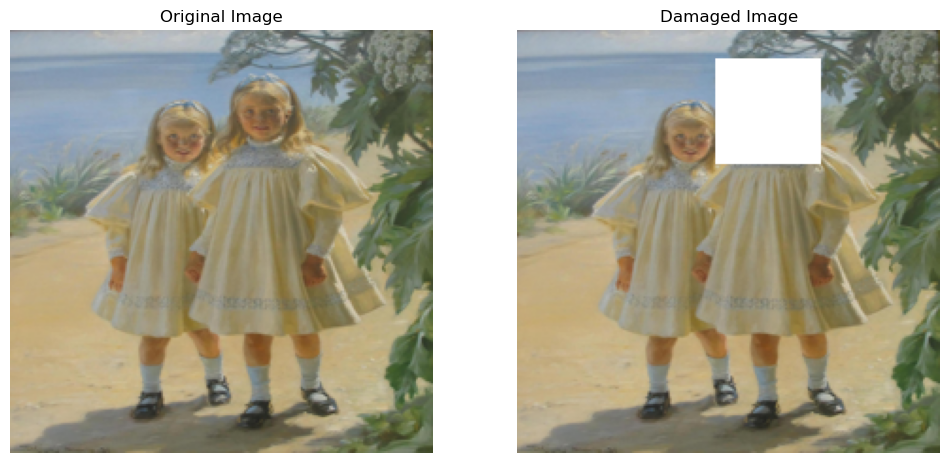

In [220]:
def select_image_for_inpainting():
        
    import os
    import random
    import numpy as np
    import pandas as pd
    from PIL import Image, ImageDraw
    import matplotlib.pyplot as plt
    
    # Define the RandomMask class
    class RandomMask:
        def __init__(self, max_size_fraction=1/16, max_vertices=8, mask_choice=None):
            self.mask_max_size = max_size_fraction
            self.max_vertices = max_vertices
            self.mask_choice = mask_choice
    
        def __call__(self, image):
            if self.mask_choice is None:
                self.mask_choice = random.choice(["square", "random_square", "random_polygon"])
    
            im_width, im_height = image.size
            total_pixels = im_width * im_height
            target_pixels = int(total_pixels * self.mask_max_size)  # Desired damaged pixels
    
            if self.mask_choice == "square":
                side_length = int(target_pixels ** 0.5)
                x = random.randint(0, im_width - side_length)
                y = random.randint(0, im_height - side_length)
                image.paste((255, 255, 255), (x, y, x + side_length, y + side_length))
    
            elif self.mask_choice == "random_square":
                small_mask_size = 10  # Size of small squares
                iterations = target_pixels // (small_mask_size * small_mask_size)
                for _ in range(iterations):
                    x = random.randint(0, im_width - small_mask_size)
                    y = random.randint(0, im_height - small_mask_size)
                    image.paste((255, 255, 255), (x, y, x + small_mask_size, y + small_mask_size))
    
            elif self.mask_choice == "random_polygon":
                draw = ImageDraw.Draw(image)
                num_vertices = random.randint(3, self.max_vertices)
                radius = int((target_pixels / (num_vertices * np.sin(2 * np.pi / num_vertices) * 0.5)) ** 0.5)
    
                # Generate a regular polygon around a random center
                center_x = random.randint(radius, im_width - radius)
                center_y = random.randint(radius, im_height - radius)
                vertices = [
                    (
                        int(center_x + radius * np.cos(2 * np.pi * i / num_vertices)),
                        int(center_y + radius * np.sin(2 * np.pi * i / num_vertices))
                    )
                    for i in range(num_vertices)
                ]
    
                # Draw the polygon
                draw.polygon(vertices, fill=(255, 255, 255))
    
            return image
    
    
    def apply_mask_to_image(image_path, mask_transform):
        # Load the image
        image = Image.open(image_path).convert("RGB")
    
        # Resize the image to 224x224
        image = image.resize((224, 224))
    
        # Apply the mask
        damaged_image = mask_transform(image.copy())
    
        # Display the original and damaged images using matplotlib
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
        # Show original image
        ax[0].imshow(image)
        ax[0].axis('off')
        ax[0].set_title("Original Image")
    
        # Show damaged image
        ax[1].imshow(damaged_image)
        ax[1].axis('off')
        ax[1].set_title("Damaged Image")
    
        plt.show()
    
        return damaged_image
    
    
    # File selection from CSV
    csv_file = "validate_csv_test.csv"
    root_dir = r"C:\Users\Adas\Desktop\sium sem 2\UNN\UN_projekyt\WikiArt-Impainting_Images-master"
    
    # Read CSV and construct full file paths
    try:
        df = pd.read_csv(csv_file)
        file_list = [os.path.join(root_dir, file) for file in df['file']]
    except Exception as e:
        print(f"Error reading CSV file: {e}")
        file_list = []
    
    # Check if the CSV contains any valid file paths
    if not file_list:
        print("No valid image paths found in the CSV file.")
    else:
        # Display available files with indices
        #for idx, file_name in enumerate(file_list):
            #print(f"{idx}: {file_name}")
    
        while True:
            try:
                # Input to select an image by index
                selected_index = int(input("Enter the index of the image you want to select: "))
                if 0 <= selected_index < len(file_list):
                    break
                else:
                    print(f"Please enter a number between 0 and {len(file_list) - 1}.")
            except ValueError:
                print("Invalid input. Please enter a valid integer.")
    
        selected_file = file_list[selected_index]
    
        # Ask the user which mask to apply
        mask_choice = input("Enter mask choice (square, random_square, random_polygon): ").lower()
    
        # Create the mask transformer with the user's choice
        mask_transform = RandomMask(mask_choice=mask_choice if mask_choice else None)
    
        # Apply the mask to the selected image
        test_image = apply_mask_to_image(selected_file, mask_transform)
    
        # Save the resulting damaged image to the 'test_image' variable
        #test_image.save("damaged_image.jpg")  # You can change the file name here if desired
    
        #print("The damaged image has been saved as 'damaged_image.jpg'.")
        original_image = Image.open(selected_file).convert("RGB")
    
        # Resize the image to 224x224
        original_image.resize((224, 224))
        return test_image, original_image
test_image, original_image = select_image_for_inpainting()

In [244]:
def extract_features_from_image(test_image):
    
    import torch
    import torch.nn as nn
    from torchvision import models, transforms
    
    # Define the ModifiedResNet18 class (from your provided code)
    resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    feature_extractor = torch.nn.Sequential(*list(resnet.children())[:-1])
    
    latent_dim = 200
    fc_layer = nn.Linear(512, latent_dim)
    
    class ModifiedResNet18(nn.Module):
        def __init__(self, feature_extractor, fc_layer):
            super(ModifiedResNet18, self).__init__()
            self.feature_extractor = feature_extractor
            self.fc_layer = fc_layer
    
        def forward(self, x):
            features = self.feature_extractor(x)
            features = features.view(features.size(0), -1)  # Flatten the features
            latent_space = self.fc_layer(features)
            return latent_space
    
    # Initialize the modified ResNet-18 model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    modified_resnet = ModifiedResNet18(feature_extractor, fc_layer).to(device)
    
    # Define a transformation pipeline for the input image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to ResNet input size
        transforms.ToTensor(),          # Convert to tensor
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], # Normalization values for pre-trained ResNet
            std=[0.229, 0.224, 0.225]
        )
    ])
    
    # Ensure test_image exists and apply the transformation
    if 'test_image' in locals():
        try:
            test_image_tensor = transform(test_image).unsqueeze(0).to(device)  # Add batch dimension
    
            # Extract latent space
            modified_resnet.eval()  # Set model to evaluation mode
            with torch.no_grad():
                latent_space = modified_resnet(test_image_tensor)
    
            # Print the latent space
            print("Latent space representation:", latent_space.cpu().numpy())
            latent_space = latent_space.cpu().numpy()
        except Exception as e:
            print(f"Error processing the test_image: {e}")
    else:
        print("test_image not found. Please ensure the masking code has been executed.")

    return  latent_space
latent_space = extract_features_from_image(test_image)

Latent space representation: [[-3.36012542e-02  4.75738585e-01  3.25816274e-01 -2.56841421e-01
   1.97036266e-01 -1.10312378e+00 -2.17025325e-01  2.79501557e-01
   7.04433024e-01  9.69628692e-01 -4.84482795e-01  8.86626720e-01
  -3.64894509e-01 -1.50526494e-01 -6.10031724e-01 -1.95990741e-01
   3.63216728e-01  9.70036983e-01 -2.08271667e-01 -5.78989498e-02
   4.24075499e-03  2.35013351e-01  7.71768391e-04  3.23911935e-01
   8.60284790e-02  4.91801471e-01 -2.05045417e-01  3.87004614e-01
  -8.52262318e-01 -3.48838381e-02  3.06600153e-01  8.46351683e-02
  -3.36336158e-03  2.79637456e-01  5.19671261e-01 -1.31755412e-01
   1.45204335e-01 -4.35859054e-01 -9.40921664e-01  5.50481856e-01
  -1.65689439e-01 -1.00592220e+00  1.05608559e+00  2.29454011e-01
   8.04280341e-01  9.67418969e-01 -1.62078142e-01  7.77412891e-01
   2.32120454e-01  8.94916356e-01  8.85613263e-03 -9.29595411e-01
   4.22727615e-01  6.83889508e-01  3.27836275e-01 -5.27472317e-01
   4.13323402e-01 -9.38280463e-01 -2.19950482e-

In [246]:
def extract_and_reduce_features_from_image(test_image):
    import torch
    import torch.nn as nn
    from torchvision import models, transforms
    import joblib
    

    resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    feature_extractor = torch.nn.Sequential(*list(resnet.children())[:-1])
    
    latent_dim = 200
    fc_layer = nn.Linear(512, latent_dim)
    
    class ModifiedResNet18(nn.Module):
        def __init__(self, feature_extractor, fc_layer):
            super(ModifiedResNet18, self).__init__()
            self.feature_extractor = feature_extractor
            self.fc_layer = fc_layer
    
        def forward(self, x):
            features = self.feature_extractor(x)
            features = features.view(features.size(0), -1)  # Flatten the features
            latent_space = self.fc_layer(features)
            return latent_space
    

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    modified_resnet = ModifiedResNet18(feature_extractor, fc_layer).to(device)
    
    # Define a transformation pipeline for the input image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  
        transforms.ToTensor(),          
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], # Normalization values for pre-trained ResNet
            std=[0.229, 0.224, 0.225]
        )
    ])
    
    # Ensure test_image exists and apply the transformation
    reduced_latent_space = None
    if 'test_image' in locals():
        try:
            # Transform the test image
            test_image_tensor = transform(test_image).unsqueeze(0).to(device)  # Add batch dimension
    
            # Extract latent space
            modified_resnet.eval()  # Set model to evaluation mode
            with torch.no_grad():
                latent_space = modified_resnet(test_image_tensor).cpu().numpy()
    
            # Print the latent space
            print("Latent space representation:", latent_space)
    
            # Load the saved PCA model
            pca_model_path = "pca_4_components_200.pkl"
            pca = joblib.load(pca_model_path)
    
            # Reduce the latent space to 102 dimensions using PCA
            reduced_latent_space = pca.transform(latent_space)
            print("Reduced latent space representation:", reduced_latent_space)
    
        except Exception as e:
            print(f"Error processing the test_image: {e}")
    else:
        print("test_image not found. Please ensure the masking code has been executed.")

    return reduced_latent_space

reduced_latent_space = extract_and_reduce_features_from_image(test_image)


Latent space representation: [[ 0.12320302  0.5877353   0.21277954  1.1391242  -0.65605706  0.9232523
   0.05872949 -0.85611784  0.17178427  0.5480461   0.79371387 -0.00937927
   2.060197   -0.36123472  0.7707423   0.40591872  0.27274242  0.3016214
  -0.47602683  0.65116304  0.25110933 -0.8890159  -0.80295914 -0.27628464
  -0.46105456 -0.02236228  0.6640182  -0.5770241   0.9535192   0.39447242
  -0.85373586 -0.29440057  0.11156472  0.07721139  0.66092366 -0.24601455
  -0.7357011   0.02223875  0.08373442 -1.0645921  -0.08429572  0.14867754
  -0.35582486  0.9095458   0.99906474 -0.834127   -0.71945065  0.22608545
   0.33025342  0.5501069   0.14037776  0.50048614 -0.05703201 -0.07781892
   1.012323   -0.26017994  0.21522343 -0.03409631  0.40639043  0.05817029
   0.14366208  0.32723022  0.5145874  -0.6039017   0.3973761   0.2774859
  -0.11933374  0.33221868 -0.12370269 -0.6438066   1.1883726   1.1862388
  -0.8428238   0.7655539  -0.14230016 -0.51764846  0.39964962  0.02801953
   0.129397  

In [174]:
test_image_reduced_latent_space.shape

(1, 102)

Distance to cluster 0: 8.743375986590717
Distance to cluster 1: 10.010398079883318
Distance to cluster 2: 9.941533862633923
Distance to cluster 3: 9.020913509247512
Distance to cluster 4: 9.530540690227166
Distance to cluster 5: 9.76563443341625
Distance to cluster 6: 8.881441505204899
Distance to cluster 7: 9.83654645829685
Distance to cluster 8: 10.202301676899578
Distance to cluster 9: 9.558885559293413

Test image assigned to cluster: 0
Distance to the nearest cluster center: 8.743375986590717
Error assigning test image to a cluster: too many values to unpack (expected 2)


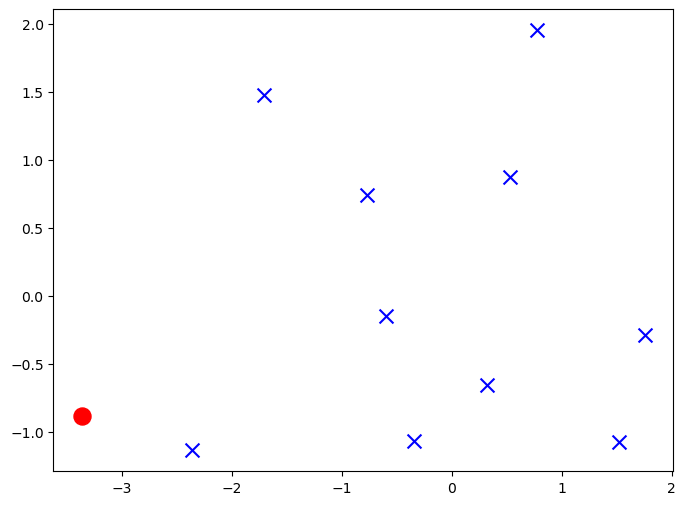

In [239]:
def assign_cluster_with_visualization(test_image_reduced_latent_space):
    import numpy as np
    from scipy.spatial.distance import cdist
    import joblib
    import matplotlib.pyplot as plt

    # Check if the test image latent space exists
    if 'test_image_reduced_latent_space' in locals():
        try:
            # Load the K-Means model and its cluster centers
            kmeans_model = joblib.load("kmeans_102_clusters.pkl")  # Replace with the correct file if needed
            cluster_centers = kmeans_model.cluster_centers_
    
            # Ensure the input is a NumPy array
            test_image_reduced_latent_space_np = np.array(test_image_reduced_latent_space)
    
            # Compute distances to all cluster centers
            distances = cdist(test_image_reduced_latent_space_np, cluster_centers, metric='euclidean')
    
            # Print distances to all cluster centers
            for idx, distance in enumerate(distances[0]):
                print(f"Distance to cluster {idx}: {distance}")
    
            # Find and print the nearest cluster
            nearest_cluster = np.argmin(distances)
            print(f"\nTest image assigned to cluster: {nearest_cluster}")
            print(f"Distance to the nearest cluster center: {distances[0, nearest_cluster]}")
    
            # Visualize the clusters and the test image
            plt.figure(figsize=(8, 6))
            
            # Scatter plot for cluster centers ('x' markers)
            plt.scatter(
                cluster_centers[:, 0], cluster_centers[:, 1],
                c='blue', label='Cluster Centers', marker='x', s=100
            )
            
            # Scatter plot for the test image ('o' marker)
            plt.scatter(
                test_image_reduced_latent_space_np[0, 0], test_image_reduced_latent_space_np[0, 1],
                c='red', label='Test Image', marker='o', s=150
            )
            
            # Annotate distances for each cluster center
            for idx, (x, y) in enumerate(cluster_centers):
                plt.text(x, y, f'{idx}', fontsize=9, ha='right', va='bottom', color='blue')
                plt.plot(
                    [x, test_image_reduced_latent_space_np[0, 0]],
                    [y, test_image_reduced_latent_space_np[0, 1]],
                    linestyle='--', color='gray', linewidth=0.8
                )
            
            plt.title("Cluster Centers and Test Image")
            plt.xlabel("Dimension 1")
            plt.ylabel("Dimension 2")
            plt.legend()
            plt.grid(True)
            plt.show()
    
        except Exception as e:
            print(f"Error assigning test image to a cluster: {e}")
    else:
        print("test_image_reduced_latent_space not found. Please ensure the PCA transformation code has been executed.")

    return nearest_cluster

# Example usage (ensure `test_image_reduced_latent_space` is properly defined):
assigned_cluster = assign_cluster_with_visualization(test_image_reduced_latent_space)


In [230]:
import joblib
import numpy as np

# Load the K-Means model from the file
kmeans_model_path = "kmeans_102_clusters.pkl"
try:
    kmeans_model = joblib.load(kmeans_model_path)
    cluster_centers = kmeans_model.cluster_centers_

    # Display the coordinates of the cluster centers
    print("Cluster Centers' Coordinates:")
    for idx, center in enumerate(cluster_centers):
        print(f"Cluster {idx}: {center}")

except Exception as e:
    print(f"Error loading the K-Means model or extracting cluster centers: {e}")


Cluster Centers' Coordinates:
Cluster 0: [-1.7047156e+00  1.4751697e+00  9.8409444e-01 -4.0552735e-01
  5.7727337e-01 -2.2638874e-02  6.8983994e-02 -1.4604087e-01
  1.9627140e-01  5.9953187e-02 -1.5552190e-01 -1.3357608e-01
  2.1245216e-01 -2.3983148e-01 -6.0248833e-02 -4.7208700e-02
 -2.3350181e-01 -1.4160345e-01 -1.3412939e-01 -9.1796517e-02
 -5.3833727e-02  7.7484526e-02 -1.4857517e-02 -2.5676014e-02
  8.9831188e-02 -8.3051153e-02 -1.5395471e-01 -9.0451501e-03
 -1.2148372e-01 -3.6285207e-02 -2.7260989e-02 -5.6793757e-02
 -1.0108396e-01  8.7387778e-04 -8.0517173e-02 -4.4905059e-02
  5.9638448e-02  3.0044524e-02 -1.5067278e-02 -2.9306773e-02
  5.7765301e-03  6.5728113e-02 -8.5376697e-03  8.3455428e-02
 -3.1775113e-03  5.3687108e-04  4.8834361e-02  6.9396710e-03
  2.4662800e-02 -1.4025902e-02 -3.5612170e-02  3.9596263e-02
 -5.5112638e-02 -1.4392898e-02  9.0302331e-03 -8.8009238e-03
  1.6851818e-02  5.1612120e-02  5.6121711e-02 -1.3745971e-02
 -8.5952111e-02 -2.2439064e-02 -3.8967859e-0

C:\Users\Adas\AppData\Local\Temp\ipykernel_14596\4028970537.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(weights_path, map_location=device)
C

Test image assigned to cluster: 6
Loading autoencoder weights from: inpainting_autoencoder_cluster_6_done.pth
damage_image_tensor: torch.Size([1, 3, 224, 224])


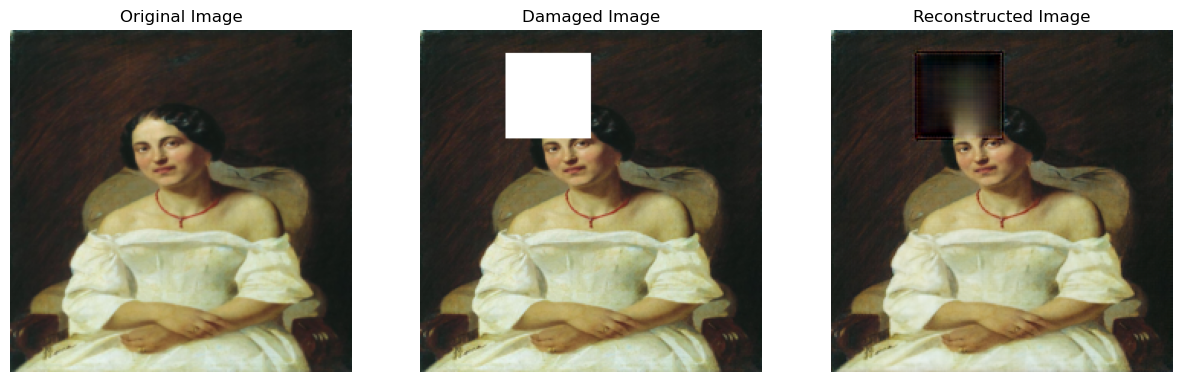

In [125]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image


#try this auto:

import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        identity = x
        out = self.relu(self.conv1(x))
        out = self.conv2(out)
        return self.relu(out + identity)  # Add skip connection

class InpaintingAutoencoder(nn.Module):
    def __init__(self):
        super(InpaintingAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  # 64x112x112
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 128x56x56
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 256x28x28
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # 512x14x14
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1),  # 512x7x7
            nn.ReLU()
        )

        # Bottleneck with extended capacity and residual learning
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=2, dilation=2),  # Dilated convolution
            nn.ReLU(),
            ResidualBlock(1024, 1024),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=4, dilation=4),  # Larger receptive field
            nn.ReLU(),
            ResidualBlock(1024, 1024)
        )

        # Decoder with skip connections and residual blocks
        self.decoder = nn.ModuleDict({
            "deconv4": nn.Sequential(
                nn.ConvTranspose2d(1024 + 512, 256, kernel_size=4, stride=2, padding=1),  # 256x28x28
                nn.ReLU(),
                ResidualBlock(256, 256)
            ),
            "deconv3": nn.Sequential(
                nn.ConvTranspose2d(256 + 256, 128, kernel_size=4, stride=2, padding=1),  # 128x56x56
                nn.ReLU(),
                ResidualBlock(128, 128)
            ),
            "deconv2": nn.Sequential(
                nn.ConvTranspose2d(128 + 128, 64, kernel_size=4, stride=2, padding=1),  # 64x112x112
                nn.ReLU(),
                ResidualBlock(64, 64)
            ),
            "deconv1": nn.Sequential(
                nn.ConvTranspose2d(64 + 64, 3, kernel_size=4, stride=2, padding=1),  # 3x224x224
                nn.Tanh()  # If you normalize inputs to [-1, 1]
            )
        })

    def forward(self, x):
        # Encode input
        enc1 = self.encoder[0:2](x)  # 64x112x112
        enc2 = self.encoder[2:4](enc1)  # 128x56x56
        enc3 = self.encoder[4:6](enc2)  # 256x28x28
        enc4 = self.encoder[6:8](enc3)  # 512x14x14
        bottleneck = self.bottleneck(enc4)  # 1024x7x7

        # Decode with skip connections
        dec4 = self.decoder["deconv4"](torch.cat([bottleneck, enc4], dim=1))  # 256x28x28
        dec3 = self.decoder["deconv3"](torch.cat([dec4, enc3], dim=1))  # 128x56x56
        dec2 = self.decoder["deconv2"](torch.cat([dec3, enc2], dim=1))  # 64x112x112
        dec1 = self.decoder["deconv1"](torch.cat([dec2, enc1], dim=1))  # 3x224x224

        return bottleneck, dec1


# Function to preprocess a PIL.Image.Image into a tensor
def preprocess_image(image, image_size=(224, 224)):
    preprocess = transforms.Compose([
        transforms.Resize(image_size),  # Resize to the expected input size
        transforms.ToTensor(),         # Convert to tensor
    ])
    return preprocess(image).unsqueeze(0)  # Add batch dimension

# Visualize original, damaged, and reconstructed images
def visualize_images(original, damaged, reconstructed):
    # Convert tensors to images
    original = original.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    damaged = damaged.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    reconstructed = reconstructed.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()

    # Plot side-by-side
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(original)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(damaged)
    axes[1].set_title('Damaged Image')
    axes[1].axis('off')

    axes[2].imshow(reconstructed)
    axes[2].set_title('Reconstructed Image')
    axes[2].axis('off')

    plt.show()


# Initialize the autoencoder and reconstruct the image
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder = InpaintingAutoencoder()

# Load the autoencoder weights
checkpoint = torch.load(weights_path, map_location=device)
autoencoder.load_state_dict(checkpoint['model_state_dict'])
autoencoder = autoencoder.to(device)
autoencoder.eval()


weights_path = f"inpainting_autoencoder_cluster_{nearest_cluster}_done.pth"
print(f"Loading autoencoder weights from: {weights_path}")

# Preprocess images
original_image_tensor = preprocess_image(original_image)
damaged_image_tensor = preprocess_image(test_image)
            
# Move the damaged image to the correct device and reconstruct it
damaged_image_tensor = damaged_image_tensor.to(device)
_, reconstructed_image_tensor = autoencoder(damaged_image_tensor)
            
# Visualize the result
visualize_images(original_image_tensor, damaged_image_tensor, reconstructed_image_tensor)


